In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix,
    plot_confusion_matrix, make_scorer,multilabel_confusion_matrix,ConfusionMatrixDisplay)

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.dummy import DummyClassifier

from sklearn import tree

import warnings

from CF_5_Modelling import (add_model_score, feat_imp, scorer_pos_neg_class,
                            scorer_confusion_matrix)

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

rng = 1379543626 #int(np.random.default_rng().random()*(2**32))

#1055758638, 0.819277	0.817382	0.819695	0.819277	0.857143	0.75	0.794118	0.880952	0.878049	0.8		0.710526	0.880952	0.939759
#1379543626, 0.861446	0.851979	0.863679	0.861446	0.942857	0.818182	0.851852	0.857143	0.868421	0.882353	0.657143	1	0.945783
#2864128769, 0.795181	0.797815	0.793964	0.795181	0.840909	0.777778	0.727273	0.818182	0.840909	0.7	0.727273	0.923077	0.933735

%matplotlib inline
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data_weekly_class.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot_lag_15,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons,rig_change_4bin_week+4,rig_change_4bin_week+8,rig_pct_change_week+4,rig_pct_change_week+8
0,2011-02-04,818.0,82.030,86.752,89.520,100.358,90.678,93.31,95.278,96.458,...,86.752,47.663605,86.752,42.542887,86.752,90.206492,--,++,-0.020782,0.072127
1,2011-02-11,805.0,84.928,88.496,85.514,99.904,86.688,90.01,92.948,94.708,...,88.496,47.480506,88.496,42.376184,88.496,89.856690,++,++,0.027329,0.100621


In [4]:
num_col_rig_change = df.columns.str.contains('rig_').sum()
df = df.drop(['brent_spot','wti_fut_1','wti_fut_2','wti_fut_3','wti_fut_4','wti_spot_lag_15','wti_spot_lag_9',
              'usa_l48_prod','usa_stocks_all','usa_net_import',
              'world_cons','world_cons_smooth','oecd_cons','non-oecd_cons','non-oecd_cons_smooth',],axis=1)
df.shape

(502, 15)

## Train Test Split
Define features X, and target variable y

In [5]:
X = df.iloc[:,1:-num_col_rig_change]
y = df.loc[:,'rig_change_4bin_week+8']

old_class = ['--','-','+','++']
new_class = [int(0),int(1),int(2),int(3)]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=rng)

model_score = pd.DataFrame(columns=['accuracy','balanced accuracy','precision avg','recall avg','precision (++)','precision (+)','precision (-)','precision (--)','recall (++)','recall (+)','recall (-)','recall (--)','pos neg class','max depth'])

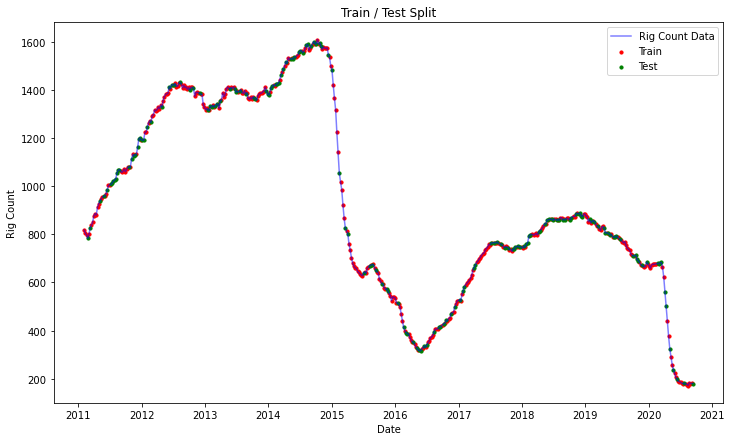

In [6]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(df.date,df['Total US RigCount'],c='b',alpha=0.5,label='Rig Count Data')
ax.scatter(df.date[y_train.sort_index().index],df['Total US RigCount'][y_train.sort_index().index],c='r',alpha=1,s=10,label='Train')
ax.scatter(df.date[y_test.sort_index().index],df['Total US RigCount'][y_test.sort_index().index], c='g',alpha=1,s=10,label='Test')
    
ax.set(title='Train / Test Split',xlabel='Date',ylabel='Rig Count')
ax.legend()
plt.show()

In [7]:
recall_neg_scorer = make_scorer(recall_score,average=None,labels=['-'],greater_is_better=True)
pos_neg_class_scorer = make_scorer(scorer_pos_neg_class,greater_is_better=True)

confusion_matrix_scorer = make_scorer(scorer_confusion_matrix)

## Baseline Dummy Classifier

In [8]:
model = DummyClassifier(strategy='stratified')
scaler = StandardScaler()
feat_sel = SelectKBest(score_func=f_classif)

grid_params = {
    'feat_sel__k': [2], #np.arange(1,X.shape[1]+1,step=1),
    'scaler': [MinMaxScaler()] #StandardScaler(), MinMaxScaler(),None]
}

model_name = 'baseline_dummy_class'

base_dummy_pipe = GridSearchCV(Pipeline([('feat_sel',feat_sel),('scaler',scaler),('model',model)]),scoring=pos_neg_class_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

base_dummy_pipe.fit(X_train,y_train)

y_pred = base_dummy_pipe.predict(X_test)

add_model_score(model_score,base_dummy_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
baseline_dummy_class,0.253012,0.248542,0.26182,0.253012,0.352941,0.288462,0.190476,0.184211,0.27907,0.288462,0.242424,0.184211,0.439759,NaN


In [9]:
pd.Series(base_dummy_pipe.best_estimator_.named_steps.feat_sel.scores_[base_dummy_pipe.best_estimator_.named_steps.feat_sel.get_support()], index=X.columns[base_dummy_pipe.best_estimator_.named_steps.feat_sel.get_support()]).sort_values(ascending=False)

wti_spot             41.580328
Total US RigCount    28.908094
dtype: float64

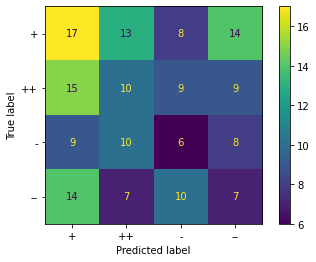

In [10]:
plot_confusion_matrix(base_dummy_pipe,X_test,y_test)

## KMeans Clustering

In [11]:
y_kmeans_train = y_train.copy()
y_kmeans_test = y_test.copy()

for i in range(len(old_class)):
    y_kmeans_train[y_kmeans_train == old_class[i]] = new_class[i]
    y_kmeans_test[y_kmeans_test == old_class[i]] = new_class[i]


In [12]:
model = KMeans(n_clusters = 4)
model_name = 'KMeans_base'

KM_base_pipe = Pipeline([('model',model)])

KM_base_pipe.fit(X_train,y_kmeans_train)

y_pred = KM_base_pipe.predict(X_test)

In [13]:
y_km_test_labelled = y_kmeans_test.copy()
y_pred_labelled = pd.Series(y_pred).copy()

for i in range(len(old_class)):
    y_km_test_labelled[y_km_test_labelled == new_class[i]] = old_class[i]
    y_pred_labelled[y_pred_labelled == new_class[i]] = old_class[i]

add_model_score(model_score,model,model_name,y_km_test_labelled,y_pred_labelled)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
KMeans_base,0.198795,0.1801,0.197269,0.198795,0.2,0.352941,0.047619,0.111111,0.186047,0.346154,0.030303,0.157895,0.421687,NaN


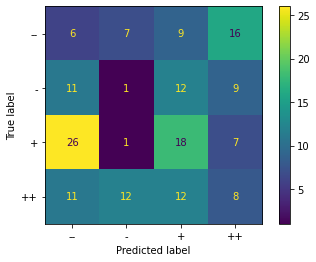

In [14]:
cm = confusion_matrix(y_km_test_labelled,y_pred_labelled,labels=old_class)

ConfusionMatrixDisplay(cm,display_labels=old_class).plot()

Wasn't expecting good performance from here, but wanted to see how similar the data is in the dimensional space. Worse than random guess (1/4), and less than 50% of the points are incorrectly classified between negative and positive.

## Random Forest Classifier

In [15]:
model = RandomForestClassifier(random_state=9552)
model_name = 'RFC_base'

grid_params={
    
}

RFC_base_pipe = GridSearchCV(Pipeline([('model',model)]),scoring=pos_neg_class_scorer,cv=5,param_grid=grid_params,n_jobs=-1)

RFC_base_pipe.fit(X_train,y_train)

y_pred = RFC_base_pipe.predict(X_test)

add_model_score(model_score,RFC_base_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_base,0.777108,0.77476,0.779171,0.777108,0.833333,0.735849,0.647059,0.891892,0.813953,0.75,0.666667,0.868421,0.915663,None


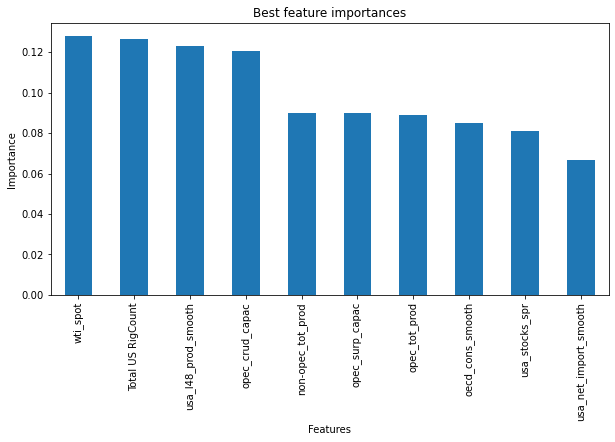

In [16]:
feat_imp(RFC_base_pipe,X)

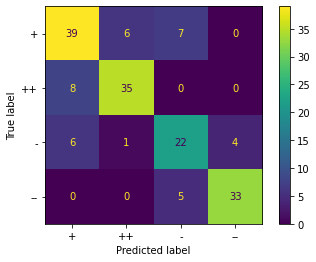

In [17]:
plot_confusion_matrix(RFC_base_pipe,X_test,y_test)

In [18]:
model = RandomForestClassifier()
scaler = StandardScaler()

grid_params = {
    'model__random_state': [9552], #np.arange(start=1, stop = 10000),
    'model__n_estimators': [56], #np.arange(start=50,stop=70,step=1),
    'model__max_depth': [8], #np.arange(1,15,step=1),
    'model__criterion': ['entropy'], #['gini','entropy'],
    'model__max_features': [2], #np.arange(1,X.shape[1]+1,step=1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

model_name = 'RFC_pos_neg_class'

RFC_pos_neg_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=pos_neg_class_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

RFC_pos_neg_pipe.fit(X_train,y_train)

y_pred = RFC_pos_neg_pipe.predict(X_test)

add_model_score(model_score,RFC_pos_neg_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_pos_neg_class,0.825301,0.819532,0.826535,0.825301,0.853659,0.77193,0.821429,0.875,0.813953,0.846154,0.69697,0.921053,0.957831,8


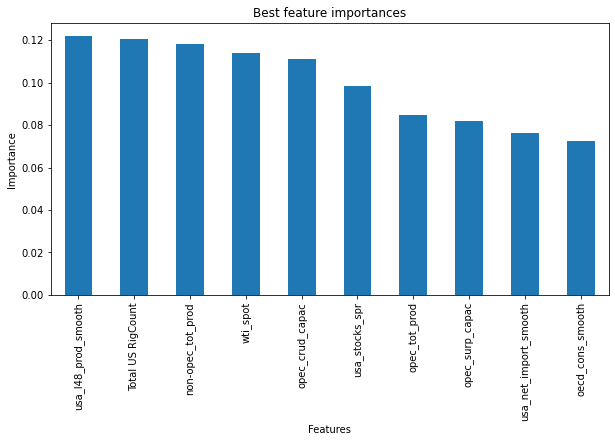

In [19]:
feat_imp(RFC_pos_neg_pipe,X)

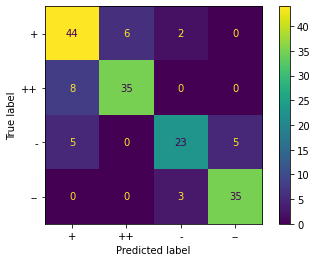

In [20]:
plot_confusion_matrix(RFC_pos_neg_pipe,X_test,y_test)

In [21]:
model = RandomForestClassifier()
scaler = StandardScaler()

grid_params = {
    'model__random_state': [9552], #np.arange(start=1, stop = 10000),
    'model__n_estimators': [44], #np.arange(start=30,stop=70,step=1),
    'model__max_depth': [3], #np.arange(1,15,step=1),
    'model__criterion': ['entropy'], #['gini','entropy'],
    'model__max_features': [3], #np.arange(1,X.shape[1]+1,step=1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

model_name = 'RFC_neg_recall'

RFC_neg_rec_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=recall_neg_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

RFC_neg_rec_pipe.fit(X_train,y_train)

y_pred = RFC_neg_rec_pipe.predict(X_test)

add_model_score(model_score,RFC_neg_rec_pipe,model_name,y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_neg_recall,0.692771,0.665227,0.724344,0.692771,0.794872,0.61194,0.833333,0.703704,0.72093,0.788462,0.151515,1,0.885542,3


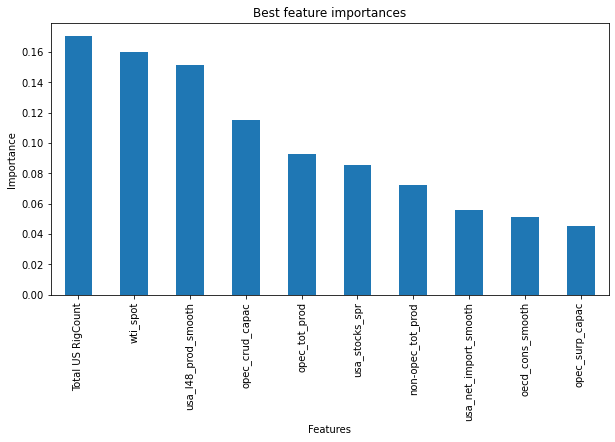

In [22]:
feat_imp(RFC_neg_rec_pipe,X)

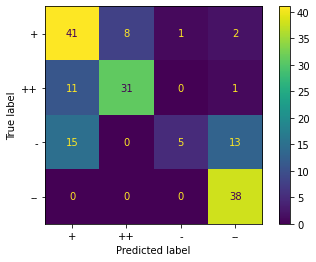

In [23]:
plot_confusion_matrix(RFC_neg_rec_pipe,X_test,y_test)

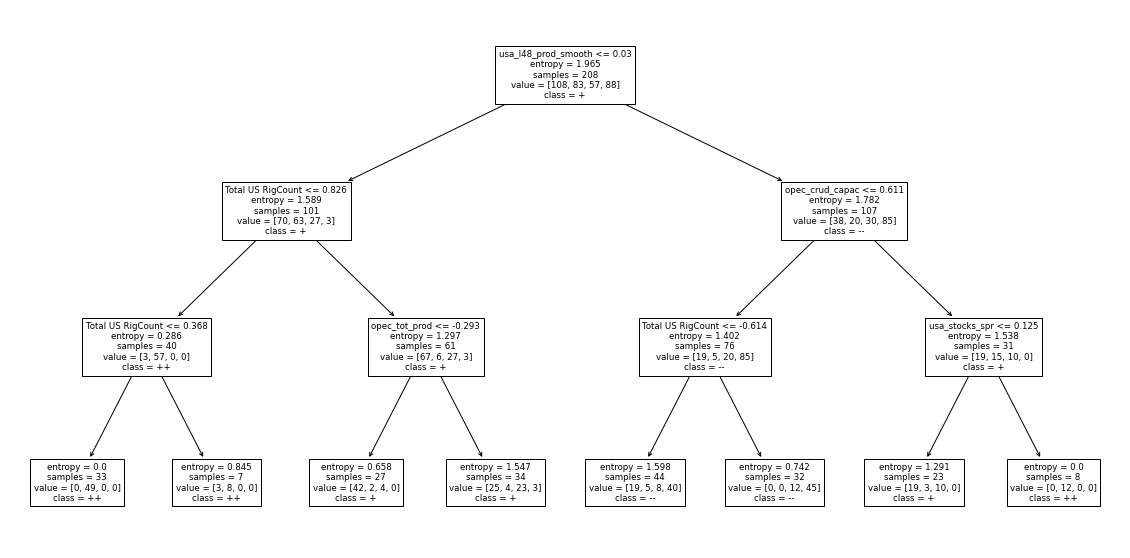

In [26]:
plt.figure(figsize=(20,10))
tree.plot_tree(RFC_neg_rec_pipe.best_estimator_.named_steps.model.estimators_[0],class_names=RFC_neg_rec_pipe.classes_,feature_names=X_train.columns)
plt.show()

In [ ]:
model_score.sort_values(by='pos neg class',ascending=False).head(3)

Two main insights into the modelling so far. 
1. Basic random forest optimisation has overall better results compared to tuned hyperparameters. 
2. The extreme classes for positive and negative have good precision, however, the less extreme classes have the highest tendencies for false negatives.
3. The model test performance depends on the train, test split and class imbalance. Here, the weakest performing model is the class with the smallest proportion (-).

Unlike the regression modelling which did not show a very high feature importance for wti_spot prices, the classification problem is showing much more significance to one of the most highly correlated features in the EDA.

## XGBClassifier

In [ ]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree')

model_name = 'XGB_base'

grid_params={

}

XGB_base_pipe = GridSearchCV(Pipeline([('model',model)]),scoring=pos_neg_class_scorer,cv=5,param_grid=grid_params,n_jobs=-1)

XGB_base_pipe.fit(X_train,y_train)

y_pred = XGB_base_pipe.predict(X_test)

add_model_score(model_score,XGB_base_pipe,model_name,y_test,y_pred)

In [ ]:
feat_imp(XGB_base_pipe,X)

In [ ]:
plot_confusion_matrix(XGB_base_pipe,X_test,y_test)

In [ ]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree')
scaler = StandardScaler()

model_name = 'XGB_pos_neg_class'

grid_params = {
    'model__learning_rate': [0.63], #np.arange(0.4,0.8,step=0.01),
    'model__n_estimators': [35], #np.arange(30,50,step=1),
    'model__max_depth' : [2], #np.arange(1,10,step=1),
    'model__gamma' : [0.7], #np.arange(0,1,step=0.1),
    'model__lambda' : [0.3], #np.arange(0,1.1,step=0.1),
    'model__alpha' : [0], #np.arange(0,1.1,step=0.1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

XGB_pos_neg_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=pos_neg_class_scorer,cv=5,param_grid=grid_params,n_jobs=-1)

XGB_pos_neg_pipe.fit(X_train,y_train)

y_pred = XGB_pos_neg_pipe.predict(X_test)

add_model_score(model_score,XGB_pos_neg_pipe,model_name,y_test,y_pred)


In [ ]:
feat_imp(XGB_pos_neg_pipe,X)

In [ ]:
plot_confusion_matrix(XGB_pos_neg_pipe,X_test,y_test)

In [ ]:
model = XGBClassifier(objective='multi:softmax',booster='gbtree')
scaler = StandardScaler()

model_name = 'XGB_neg_recall'

grid_params = {
    'model__learning_rate': [0.59], #np.arange(0.4,1,step=0.01),
    'model__n_estimators': [28], #np.arange(20,50,step=1),
    'model__max_depth' : [8], #np.arange(1,10,step=1),
    'model__gamma' : np.arange(0,1,step=0.1),
    'model__lambda' : [0.3], #np.arange(0,1.1,step=0.05),
    'model__alpha' : [0], #np.arange(0,1.1,step=0.1),
    'scaler': [StandardScaler()] #, MinMaxScaler(),None]
}

XGB_neg_rec_pipe = GridSearchCV(Pipeline([('scaler',scaler),('model',model)]),scoring=recall_neg_scorer,param_grid=grid_params,cv=5,n_jobs=-1)

XGB_neg_rec_pipe.fit(X_train,y_train)

y_pred = XGB_neg_rec_pipe.predict(X_test)

add_model_score(model_score,XGB_neg_rec_pipe,model_name,y_test,y_pred)

In [ ]:
feat_imp(XGB_neg_rec_pipe,X)

In [ ]:
plot_confusion_matrix(XGB_neg_rec_pipe,X_test,y_test)

In [ ]:
model_score = model_score.sort_values(by=['pos neg class','recall avg'],ascending=False)
model_score.to_csv(data_processed_dir+'model_score.csv')
model_score

### Summary

* The most important measurement of model performance here is to be able to correctly predict a positive, or negative change. This is defined as the "positive negative classification".
* Second is to reduce the misclassification from exteme opposites ('--' to '++')
* Finally, accuracy, precision, recall.

The RFC / XGB models consistently preform well (better than 25% random guess, dummy classifier, and KMeans), and perform better than 90% for the positive and negative classification, in addition to 80% for precision and recall.

The XGB models are much simpler (max depth = 2), however the accuracy of the models is worse by a few points across the board.

With the accuracy of the model prediction being absolutely key to the value of the model, RFC will be used for final model choice despite the more complicated parameters.

In [ ]:
from joblib import dump, load

model_out = dump(RFC_pos_neg_pipe, 'best_model.joblib')